<a href="https://colab.research.google.com/github/Sinem-B62/retail_demand_analysis/blob/main/02_guayas_modeling_and_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ziel: Entwicklung eines Machine-Learning-Modells zur Prognose der Produktnachfrage in der Region Guayas**

In [1]:
!pip install -U gdown

import pandas as pd
import requests
import io


def make_drive_url(file_id):
    return f"https://drive.google.com/uc?id={file_id}"

# Hilfsfunktion zum Laden einer CSV-Datei über eine direkte URL
def load_csv_from_url(url):
    response = requests.get(url)
    response.raise_for_status()
    return pd.read_csv(io.StringIO(response.text))

    # Verzeichnis der Datei-IDs zur besseren Übersichtlichkeit
file_ids = {
    "holiday_events": "1RMjSuqHXHTwAw_PGD5XVjhA3agaAGHDH",
    "items": "1ogMRixVhNY6XOJtIRtkRllyOyzw1nqya",
    "oil": "1Q59vk2v4WQ-Rpc9t2nqHcsZM3QWGFje_",
    "stores": "1Ei0MUXmNhmOcmrlPad8oklnFEDM95cDi",
    "train": "1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv",
    "transactions": "1PW5LnAEAiL43fI5CRDn_h6pgDG5rtBW_"
}

df_holiday_events = load_csv_from_url(make_drive_url(file_ids["holiday_events"]))
df_items          = load_csv_from_url(make_drive_url(file_ids["items"]))
df_oil            = load_csv_from_url(make_drive_url(file_ids["oil"]))
df_stores         = load_csv_from_url(make_drive_url(file_ids["stores"]))
df_transactions   = load_csv_from_url(make_drive_url(file_ids["transactions"]))


# **Datenanreicherung: Relevante Feiertage für Guayas integrieren**



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd

path = '/content/drive/MyDrive/Data Science Sinem/Time Series/df_train_filtered_top3_final.pkl'

df_train = pd.read_pickle(path)

print(f"✅ Datei geladen: {len(df_train):,} Zeilen und {len(df_train.columns)} Spalten")
df_train.head()

✅ Datei geladen: 17,455,672 Zeilen und 12 Spalten


,date,id,store_nbr,item_nbr,unit_sales,onpromotion,z_score,year,month,day,day_of_week,unit_sales_7d_avg
0,2013-01-17,622071,24,96995,2.0,False,7.867965,2013,1,17,3,2.000000
1,2013-01-18,0,24,96995,0.0,False,-0.112399,2013,1,18,4,1.000000
2,2013-01-19,0,24,96995,0.0,False,-0.112399,2013,1,19,5,0.666667
3,2013-01-20,0,24,96995,0.0,False,-0.112399,2013,1,20,6,0.500000
4,2013-01-21,0,24,96995,0.0,False,-0.112399,2013,1,21,0,0.400000


### Validierung des Datensatzes: Prüfung auf korrekte Filterung der Top-3-Produktfamilien

In diesem Schritt wird überprüft, ob der aktuell geladene Datensatz ausschließlich Artikel aus den drei zuvor definierten Hauptproduktfamilien „GROCERY I“, „BEVERAGES“ und „CLEANING“ enthält.
Dazu werden die Familienzuordnungen der im Datensatz enthaltenen Artikel mit der Artikelliste abgeglichen und auf Übereinstimmung geprüft.

In [4]:
top_3_families = ['GROCERY I', 'BEVERAGES', 'CLEANING']

merged_check = df_train.merge(
    df_items[['item_nbr', 'family']],
    on='item_nbr',
    how='left'
)

unique_families = merged_check['family'].unique()
print(f"🧩 Eindeutige Familien im geladenen Datensatz:\n{unique_families}\n")

# Überprüfung, ob alle Familien zu den Top-3 gehören
if set(unique_families).issubset(top_3_families):
    print("✅ Der Datensatz enthält ausschließlich Artikel aus den Top-3-Familien.")
else:
    print("⚠️ Achtung: Es befinden sich Artikel außerhalb der Top-3-Familien im Datensatz!")
    print("Nicht enthaltene Familien:", set(unique_families) - set(top_3_families))

🧩 Eindeutige Familien im geladenen Datensatz:
['GROCERY I' 'CLEANING' 'BEVERAGES']

✅ Der Datensatz enthält ausschließlich Artikel aus den Top-3-Familien.


In [5]:
guayas_cities = df_stores[df_stores['state'] == 'Guayas']['city'].unique()
print(f"✅ Relevante Städte in Guayas: {guayas_cities}")

✅ Relevante Städte in Guayas: ['Guayaquil' 'Daule' 'Playas' 'Libertad']


### Feiertage filtern

 Zuerst wurden alle Feiertage (national, regional und lokal) herausgefiltert, die für die Provinz Guayas relevant sind. Diese wurden in einem separaten DataFrame (holiday_to_merge) zusammengeführt.

In [6]:
df_holiday_events['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In diesem Abschnitt werden ausschließlich Feiertage berücksichtigt, die für die Provinz Guayas relevant sind.
Dabei wird die Anzahl der eindeutigen Kombinationen aus Datum und Feiertagstyp ausgegeben.

Dies bedeutet, dass nicht nur unterschiedliche Kalendertage gezählt werden, sondern jede Kombination aus

date (Datum) und

holiday_type (Art des Feiertags)

als eigener, einzigartiger Eintrag behandelt wird.

In [7]:
import gc

national_holidays = df_holiday_events[df_holiday_events['locale'] == 'National']
regional_holidays = df_holiday_events[df_holiday_events['locale_name'] == 'Guayas']
local_holidays = df_holiday_events[
    (df_holiday_events['locale'] == 'Local') &
    (df_holiday_events['locale_name'].isin(guayas_cities))
]

relevant_holidays = pd.concat([national_holidays, regional_holidays, local_holidays])
holiday_to_merge = relevant_holidays[['date', 'type']].drop_duplicates()

holiday_to_merge = holiday_to_merge.rename(columns={'type': 'holiday_type'})
print(f"  > {len(holiday_to_merge)} einzigartige Feiertagseinträge zum Mergen vorbereitet.")

  > 189 einzigartige Feiertagseinträge zum Mergen vorbereitet.


Speicher freigeben Um den Arbeitsspeicher (RAM) zu schonen, wurden alle nicht mehr benötigten, temporären DataFrames (z.B. die ursprünglichen Feiertagslisten) gelöscht.

In [8]:
del df_stores
del df_holiday_events
del national_holidays, regional_holidays, local_holidays, relevant_holidays
gc.collect()

0

Daten mergen (verbinden) Die gefilterten Feiertagsdaten wurden über die Datum-Spalte mit dem Hauptdatensatz (df_train) verbunden. Das Ergebnis ist ein neues DataFrame (df_train_final), das nun eine zusätzliche Spalte für den Feiertagstyp (holiday_type) enthält.

In [9]:
df_train['date'] = pd.to_datetime(df_train['date'])
holiday_to_merge['date'] = pd.to_datetime(holiday_to_merge['date'])

df_train_final = df_train.merge(
    holiday_to_merge,
    on='date',
    how='left'
)

del df_train
del holiday_to_merge
gc.collect()
print("  > Merge erfolgreich. 'df_train' aus RAM gelöscht.")

  > Merge erfolgreich. 'df_train' aus RAM gelöscht.


Daten bereinigen und optimieren Tage, die keine Feiertage sind, hatten nach dem Mergen einen NaN-Wert (Missing Value). Diese Lücken wurden mit dem Platzhalter "kein bestimmtes Ereignis" gefüllt. Anschließend wurde die Spalte holiday_type in den speichereffizienten Datentyp category umgewandelt.

In [10]:
df_train_final['holiday_type'] = df_train_final['holiday_type'].fillna('Kein bestimmtes Ereignis')

df_train_final['holiday_type'] = df_train_final['holiday_type'].astype('category')

print("\n--- ✅ FERTIG! ---")
print("Speicherverbrauch des finalen DataFrames 'df_train_final':")
df_train_final.info()

print("\nErgebnis (Alle Typen sind enthalten):")
print(df_train_final['holiday_type'].value_counts())


--- ✅ FERTIG! ---
Speicherverbrauch des finalen DataFrames 'df_train_final':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17510655 entries, 0 to 17510654
Data columns (total 13 columns):
 #   Column             Dtype         
---  ------             -----         
 0   date               datetime64[ns]
 1   id                 int64         
 2   store_nbr          int64         
 3   item_nbr           int64         
 4   unit_sales         float64       
 5   onpromotion        bool          
 6   z_score            float64       
 7   year               int32         
 8   month              int32         
 9   day                int32         
 10  day_of_week        int32         
 11  unit_sales_7d_avg  float32       
 12  holiday_type       category      
dtypes: bool(1), category(1), datetime64[ns](1), float32(1), float64(2), int32(4), int64(3)
memory usage: 1.1 GB

Ergebnis (Alle Typen sind enthalten):
holiday_type
Kein bestimmtes Ereignis    15659315
Event               

In [11]:
df_train_final

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,z_score,year,month,day,day_of_week,unit_sales_7d_avg,holiday_type
0,2013-01-17,622071,24,96995,2.0,False,7.867965,2013,1,17,3,2.000000,Kein bestimmtes Ereignis
1,2013-01-18,0,24,96995,0.0,False,-0.112399,2013,1,18,4,1.000000,Kein bestimmtes Ereignis
2,2013-01-19,0,24,96995,0.0,False,-0.112399,2013,1,19,5,0.666667,Kein bestimmtes Ereignis
3,2013-01-20,0,24,96995,0.0,False,-0.112399,2013,1,20,6,0.500000,Kein bestimmtes Ereignis
4,2013-01-21,0,24,96995,0.0,False,-0.112399,2013,1,21,0,0.400000,Kein bestimmtes Ereignis
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17510650,2017-07-30,0,51,2089224,0.0,False,-0.261634,2017,7,30,6,0.000000,Kein bestimmtes Ereignis
17510651,2017-07-31,0,51,2089224,0.0,False,-0.261634,2017,7,31,0,0.000000,Kein bestimmtes Ereignis
17510652,2017-08-01,124029577,51,2089224,1.0,False,1.308170,2017,8,1,1,0.142857,Kein bestimmtes Ereignis
17510653,2017-06-24,120014301,51,2089339,1.0,False,0.000000,2017,6,24,5,1.000000,Kein bestimmtes Ereignis


# **Datensatzfilterung: Erstes Quartal 2014**

In [12]:
# Zeitraum definieren
start_date = '2014-01-01'
end_date = '2014-03-31'

df_train_final = df_train_final[
    (df_train_final['date'] >= start_date) &
    (df_train_final['date'] <= end_date)
]

In [13]:
df_train_final

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,z_score,year,month,day,day_of_week,unit_sales_7d_avg,holiday_type
1226,2014-01-01,0,24,103520,0.0,False,-0.075155,2014,1,1,2,0.00,Holiday
1227,2014-01-02,0,24,103520,0.0,False,-0.075155,2014,1,2,3,0.00,Kein bestimmtes Ereignis
1228,2014-01-03,0,24,103520,0.0,False,-0.075155,2014,1,3,4,0.00,Kein bestimmtes Ereignis
1229,2014-01-04,0,24,103520,0.0,False,-0.075155,2014,1,4,5,0.00,Kein bestimmtes Ereignis
1230,2014-01-05,0,24,103520,0.0,False,-0.075155,2014,1,5,6,0.00,Kein bestimmtes Ereignis
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17365336,2014-03-31,0,51,1464218,0.0,False,-0.093183,2014,3,31,0,0.00,Kein bestimmtes Ereignis
17367496,2014-03-28,21454791,51,1464239,3.0,False,5.585169,2014,3,28,4,3.00,Kein bestimmtes Ereignis
17367497,2014-03-29,0,51,1464239,0.0,False,-0.084067,2014,3,29,5,1.50,Kein bestimmtes Ereignis
17367498,2014-03-30,0,51,1464239,0.0,False,-0.084067,2014,3,30,6,1.00,Kein bestimmtes Ereignis


## Im Rahmen des Feature Engineerings werden zeitbasierte Merkmale (Jahr, Monat, Wochentag), Lag-Features und gleitende Durchschnitte erstellt, um Trends und saisonale Effekte für XGBoost sichtbar zu machen.

In [14]:
# Lag-Features (Verzögerungen) erstellen — vergangene Verkaufswerte
df_train_final = df_train_final.sort_values(['store_nbr', 'item_nbr', 'date'])

df_train_final['lag_1'] = df_train_final['unit_sales'].shift(1)
df_train_final['lag_7'] = df_train_final['unit_sales'].shift(7)
df_train_final['lag_30'] = df_train_final['unit_sales'].shift(30)


df_train_final['rolling_std_7'] = df_train_final['unit_sales'].shift(1).rolling(window=7).std()

# Fehlende Werte nach Shifts auffüllen
cols_to_fill = ['lag_1', 'lag_7', 'lag_30', 'rolling_std_7']
df_train_final[cols_to_fill] = df_train_final[cols_to_fill].fillna(0)

df_train_final = df_train_final.set_index('date')

# Kontrolle
print("✅ Neue Features hinzugefügt:")
print(df_train_final.columns)
df_train_final

✅ Neue Features hinzugefügt:
Index(['id', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion', 'z_score',
       'year', 'month', 'day', 'day_of_week', 'unit_sales_7d_avg',
       'holiday_type', 'lag_1', 'lag_7', 'lag_30', 'rolling_std_7'],
      dtype='object')


,id,store_nbr,item_nbr,unit_sales,onpromotion,z_score,year,month,day,day_of_week,unit_sales_7d_avg,holiday_type,lag_1,lag_7,lag_30,rolling_std_7
date,,,,,,,,,,,,,,,,
2014-01-01,0,24,103520,0.0,False,-0.075155,2014,1,1,2,0.00,Holiday,0.0,0.0,0.0,0.000000
2014-01-02,0,24,103520,0.0,False,-0.075155,2014,1,2,3,0.00,Kein bestimmtes Ereignis,0.0,0.0,0.0,0.000000
2014-01-03,0,24,103520,0.0,False,-0.075155,2014,1,3,4,0.00,Kein bestimmtes Ereignis,0.0,0.0,0.0,0.000000
2014-01-04,0,24,103520,0.0,False,-0.075155,2014,1,4,5,0.00,Kein bestimmtes Ereignis,0.0,0.0,0.0,0.000000
2014-01-05,0,24,103520,0.0,False,-0.075155,2014,1,5,6,0.00,Kein bestimmtes Ereignis,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-03-31,0,51,1464218,0.0,False,-0.093183,2014,3,31,0,0.00,Kein bestimmtes Ereignis,0.0,0.0,0.0,0.000000
2014-03-28,21454791,51,1464239,3.0,False,5.585169,2014,3,28,4,3.00,Kein bestimmtes Ereignis,0.0,0.0,0.0,0.000000
2014-03-29,0,51,1464239,0.0,False,-0.084067,2014,3,29,5,1.50,Kein bestimmtes Ereignis,3.0,0.0,0.0,1.133893


In [15]:
if 'holiday_type' in df_train_final.columns:
    df_train_final = pd.get_dummies(
        df_train_final,
        columns=['holiday_type'],
        drop_first=True
    )
    print("✅ Dummy-Encoding durchgeführt.")
else:
    print("⚠️ Spalte 'holiday_type' bereits kodiert oder nicht vorhanden.")


✅ Dummy-Encoding durchgeführt.


In [16]:
# Überprüfen, welche Dummy-Spalten für holiday_type existieren
dummy_cols = [col for col in df_train_final.columns if col.startswith("holiday_type_")]
print("Erzeugte Dummy-Spalten:", dummy_cols)


Erzeugte Dummy-Spalten: ['holiday_type_Bridge', 'holiday_type_Event', 'holiday_type_Holiday', 'holiday_type_Kein bestimmtes Ereignis', 'holiday_type_Transfer', 'holiday_type_Work Day']


In [17]:
df_train_final.head()

,id,store_nbr,item_nbr,unit_sales,onpromotion,z_score,year,month,day,day_of_week,...,lag_1,lag_7,lag_30,rolling_std_7,holiday_type_Bridge,holiday_type_Event,holiday_type_Holiday,holiday_type_Kein bestimmtes Ereignis,holiday_type_Transfer,holiday_type_Work Day
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,0,24,103520,0.0,False,-0.075155,2014,1,1,2,...,0.0,0.0,0.0,0.0,False,False,True,False,False,False
2014-01-02,0,24,103520,0.0,False,-0.075155,2014,1,2,3,...,0.0,0.0,0.0,0.0,False,False,False,True,False,False
2014-01-03,0,24,103520,0.0,False,-0.075155,2014,1,3,4,...,0.0,0.0,0.0,0.0,False,False,False,True,False,False
2014-01-04,0,24,103520,0.0,False,-0.075155,2014,1,4,5,...,0.0,0.0,0.0,0.0,False,False,False,True,False,False
2014-01-05,0,24,103520,0.0,False,-0.075155,2014,1,5,6,...,0.0,0.0,0.0,0.0,False,False,False,True,False,False


In [18]:
df_train_final = df_train_final.drop('id', axis=1)


# **Aufteilung Training/Test**

In [19]:
import pandas as pd

# Datum sicherstellen
df_train_final.index = pd.to_datetime(df_train_final.index)
df_train_final = df_train_final.sort_index()

# Zeiträume festlegen
train_start = '2014-01-01'
train_end   = '2014-02-28'
test_start  = '2014-03-01'
test_end    = '2014-03-31'

# Masken auf Basis des Index erstellen
train_mask = (df_train_final.index >= train_start) & (df_train_final.index <= train_end)
test_mask  = (df_train_final.index >= test_start)  & (df_train_final.index <= test_end)

# Daten filtern
df_train = df_train_final.loc[train_mask]
df_test  = df_train_final.loc[test_mask]

# Kontrolle
print("✅ Trainingsdaten:", len(df_train),
      "Zeilen von", df_train.index.min(), "bis", df_train.index.max())

print("✅ Testdaten:", len(df_test),
      "Zeilen von", df_test.index.min(), "bis", df_test.index.max())


✅ Trainingsdaten: 513425 Zeilen von 2014-01-01 00:00:00 bis 2014-02-28 00:00:00
✅ Testdaten: 284578 Zeilen von 2014-03-01 00:00:00 bis 2014-03-31 00:00:00


In [20]:
target_col = 'unit_sales'

feature_cols = [
    'store_nbr',
    'item_nbr',
    'onpromotion',
    'z_score',
    'year',
    'month',
    'day_of_week',
    'unit_sales_7d_avg',
    'lag_1',
    'lag_7',
    'lag_30',
    'rolling_std_7',
    'holiday_type_Bridge',
    'holiday_type_Event',
    'holiday_type_Holiday',
    'holiday_type_Kein bestimmtes Ereignis',
    'holiday_type_Transfer',
    'holiday_type_Work Day',
]

# Trainingsdaten trennen
X_train = df_train[feature_cols]
y_train = df_train[target_col]

# 🔹 Testdaten trennen
X_test = df_test[feature_cols]
y_test = df_test[target_col]

# Kontrolle
print("Feature-Matrix (Train):", X_train.shape)
print("Target (Train):", y_train.shape)
print("Feature-Matrix (Test):", X_test.shape)
print("Target (Test):", y_test.shape)

Feature-Matrix (Train): (513425, 18)
Target (Train): (513425,)
Feature-Matrix (Test): (284578, 18)
Target (Test): (284578,)


# **XGBoost-Modellaufbau**
zur Vorhersage von numerischen Werten in dem Fall Verkaufszahlen

## XGBoost-Baseline

n_estimators=250 = Anzahl der Bäume:
Das Modell besteht aus 250 Entscheidungsbäumen. Mehr Bäume = stärkeres Modell (aber langsamer).

learning_rate=0.1 = Lernrate:
Wie stark jeder neue Baum die Gesamtvorhersage korrigiert. Kleinere Werte lernen langsamer, aber stabiler.


max_depth=7 = Maximale Tiefe der Bäume:
Wie viele „Fragen“ ein Baum stellen darf. Tiefer = komplexer, aber riskanter (Overfitting).

random_state=42 = Zufallsstartwert:
Damit die Ergebnisse reproduzierbar bleiben.

n_jobs=-1 = Anzahl der Prozessorkerne:
-1 bedeutet: benutze alle verfügbaren Kerne, um schneller zu rechnen.

In [21]:
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=250,
    learning_rate=0.1,
    max_depth=7,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("✅ Modell trainiert! Anzahl Vorhersagen:", len(y_pred))


✅ Modell trainiert! Anzahl Vorhersagen: 284578


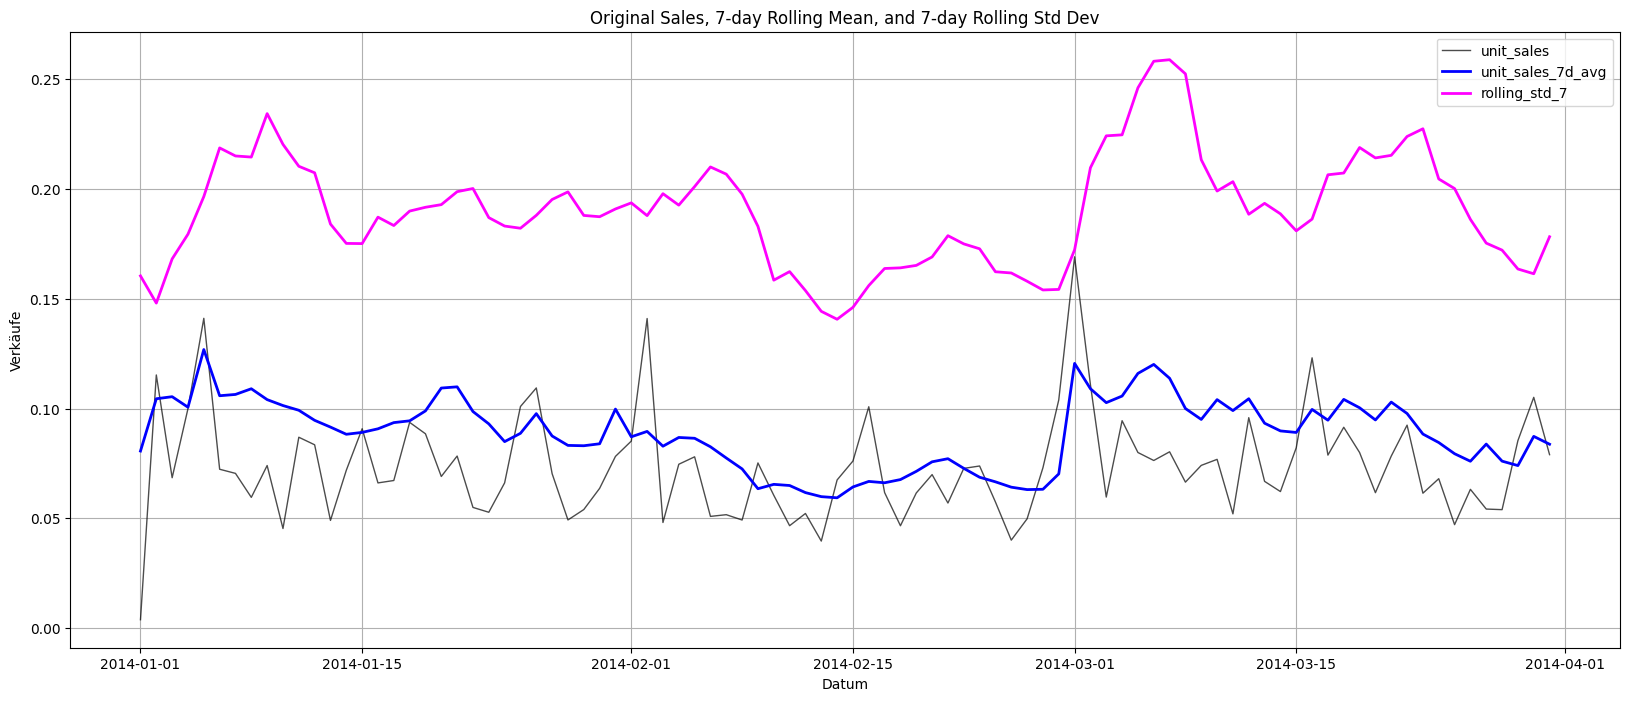

In [22]:
import matplotlib.pyplot as plt

daily_sales = df_train_final[['unit_sales', 'unit_sales_7d_avg', 'rolling_std_7']].resample('D').mean()

plt.figure(figsize=(20, 8))
plt.plot(daily_sales.index, daily_sales['unit_sales'], label='unit_sales', color='black',linewidth=1, alpha=0.7)
plt.plot(daily_sales.index, daily_sales['unit_sales_7d_avg'], label='unit_sales_7d_avg', linewidth=2,  color='blue')
plt.plot(daily_sales.index, daily_sales['rolling_std_7'], label='rolling_std_7', linewidth=2,  color='magenta')
plt.title('Original Sales, 7-day Rolling Mean, and 7-day Rolling Std Dev')
plt.xlabel('Datum')
plt.ylabel('Verkäufe')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = pd.Series(y_pred, index=y_test.index)

print("Länge y_test:", len(y_test))
print("Länge y_pred:", len(y_pred))


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Absolut Error : {mae:.4f} units: Das Modell sagt sehr nah an den echten Werten voraus.")
print(f"Mean Squared Error : {mse:.4f} units: Es gibt einzelne größere Fehler, aber insgesamt ist das Modell stabil.")


Länge y_test: 284578
Länge y_pred: 284578
Mean Absolut Error : 0.0232 units: Das Modell sagt sehr nah an den echten Werten voraus.
Mean Squared Error : 0.7358 units: Es gibt einzelne größere Fehler, aber insgesamt ist das Modell stabil.


## Bewertung meiner XGBoost-Baseline

Der gezeigte Code definiert eine Funktion zur Bewertung der Modellleistung anhand typischer Prognosemetriken.
Mit der Funktion forecast_metrics(y_true, y_pred) werden wichtige Kennzahlen berechnet, die zeigen, wie gut das XGBoost-Modell die Verkaufszahlen vorhersagt.

Dazu gehören:

- MAE (Mean Absolute Error): durchschnittlicher absoluter Fehler – misst die Genauigkeit.

- Bias: zeigt, ob das Modell systematisch über- oder unterschätzt.

- MAD / rMAD: mittlere absolute Abweichung und deren relatives Verhältnis.

- MAPE (Mean Absolute Percentage Error): prozentuale Abweichung der Vorhersagen vom tatsächlichen Wert.

- RMSE (Root Mean Squared Error): gibt stärkere Gewichtung auf größere Fehler.

Diese Metriken sind entscheidend, um die Qualität eines Prognosemodells objektiv zu bewerten.
Sie ermöglichen es, Stärken und Schwächen des Modells zu erkennen und bilden die Grundlage für die spätere Optimierung des XGBoost-Modells.

Der Code liefert den ersten, quantitativen Beweis, wie zuverlässig deine Baseline-Vorhersage wirklich ist – ein essenzieller Schritt im gesamten Machine-Learning-Projekt.

In [24]:
import numpy as np

def forecast_metrics(y_true, y_pred):
    """
    Compute a common set of forecast-error statistics.

    Parameters
    ----------
    y_true : 1-D array-like
        Actual (ground-truth) values.
    y_pred : 1-D array-like
        Forecasted values.

    Returns
    -------
    dict
        Keys: 'MAE', 'Bias', 'MAD', 'rMAD', 'MAPE', 'RMSE'
    """
    y_true = np.asarray(y_true, dtype=float).flatten()
    y_pred = np.asarray(y_pred, dtype=float).flatten()

    errors       = y_true - y_pred
    abs_errors   = np.abs(errors)
    pct_errors   = abs_errors / np.where(y_true == 0, np.nan, y_true)

    mae   = abs_errors.mean()
    bias  = errors.mean()
    rmse  = np.sqrt((errors ** 2).mean())

    mad   = np.abs(y_true - y_true.mean()).mean()

    rmad  = mae / mad if mad else np.nan

    mape  = np.nanmean(pct_errors) * 100

    return {
        "MAE" : mae,
        "Bias": bias,
        "MAD" : mad,
        "rMAD": rmad,
        "MAPE": mape,
        "RMSE": rmse
    }

In [25]:
metrics = forecast_metrics(y_test, y_pred)
for k, v in metrics.items():
    print(f"{k}: {v:,.2f}")

MAE: 0.02
Bias: 0.01
MAD: 0.16
rMAD: 0.15
MAPE: 23.04
RMSE: 0.86


## Optimierung von XGBoost-Baseline: Hyperparamtertuning



In diesem Abschnitt wird die Leistungsfähigkeit des XGBoost-Modells durch gezieltes Hyperparametertuning verbessert.
Anstatt feste Parameter zu verwenden, wird hier mit einer RandomizedSearchCV eine Vielzahl möglicher Parameterkombinationen getestet, um jene Konfiguration zu finden, die den niedrigsten Fehler (RMSE) erzielt.

**Vorgehen:**

Parameterraum definieren:
Es werden verschiedene Wertebereiche für wichtige Parameter festgelegt, z. B.

- learning_rate: Lernrate des Modells

- max_depth: maximale Baumtiefe

- subsample & colsample_bytree: Anteil der Daten und Features pro Baum

- n_estimators: Anzahl der Entscheidungsbäume

Zeitreihen-Cross-Validation (TimeSeriesSplit):
Da es sich um Zeitreihendaten handelt, wird eine spezielle Validierung verwendet, die den zeitlichen Verlauf respektiert – das verhindert Datenleckagen.

RandomizedSearchCV:
Diese Methode wählt zufällig Kombinationen aus dem Parameterraster aus und testet sie, um die besten Parameter effizient zu finden (schneller als GridSearchCV).

Trainieren & Bewerten:
Mit den optimalen Parametern wird das finale Modell neu trainiert und anhand der zuvor definierten Metriken (MAE, RMSE, MAPE usw.) bewertet.

Visualisierung:
Die grafische Darstellung zeigt die tatsächlichen Verkaufszahlen im Vergleich zu den vorhergesagten Werten — ein wichtiger Schritt zur visuellen Bewertung der Modellqualität.

In [26]:
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

xgb = XGBRegressor(objective='reg:squarederror')

In [27]:
# Definition von Parameterraster
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'n_estimators': [100, 200, 300, 500]
}

tscv = TimeSeriesSplit()

random_search = RandomizedSearchCV(estimator=xgb,
																	 param_distributions=param_grid,
                                   cv=tscv,
                                   n_iter=10,
                                   scoring='neg_mean_squared_error')

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print("Best Parameters for XGBoost:", best_params)

final_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    learning_rate=best_params["learning_rate"],
    subsample=best_params["subsample"],
    colsample_bytree=best_params["colsample_bytree"],
    random_state=42
)

# Train the model
final_model.fit(X_train, y_train)

# Make predictions
y_pred = final_model.predict(X_test)

metrics = forecast_metrics(y_test, y_pred)
for k, v in metrics.items():
    print(f"{k}: {v:,.2f}")


Best Parameters for XGBoost: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
MAE: 0.03
Bias: 0.01
MAD: 0.16
rMAD: 0.20
MAPE: 38.91
RMSE: 0.82


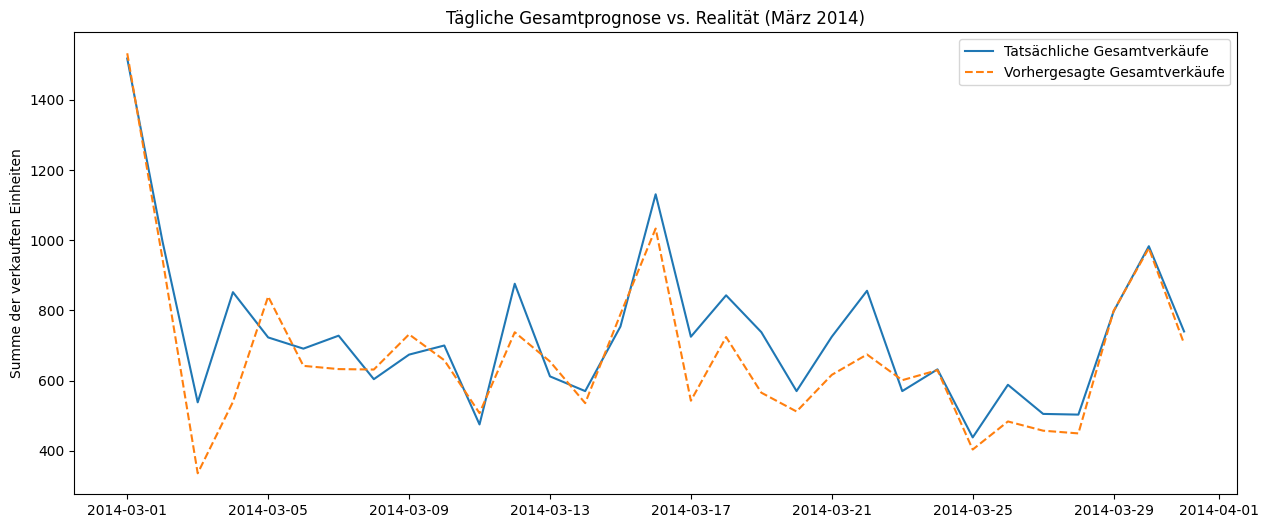

In [28]:
df_plot = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

df_daily_plot = df_plot.resample('D').sum()

plt.figure(figsize=(15, 6))
plt.plot(df_daily_plot['Actual'], label='Tatsächliche Gesamtverkäufe')
plt.plot(df_daily_plot['Predicted'], label='Vorhergesagte Gesamtverkäufe', linestyle='--')
plt.legend()
plt.title('Tägliche Gesamtprognose vs. Realität (März 2014)')
plt.ylabel('Summe der verkauften Einheiten')
plt.show()

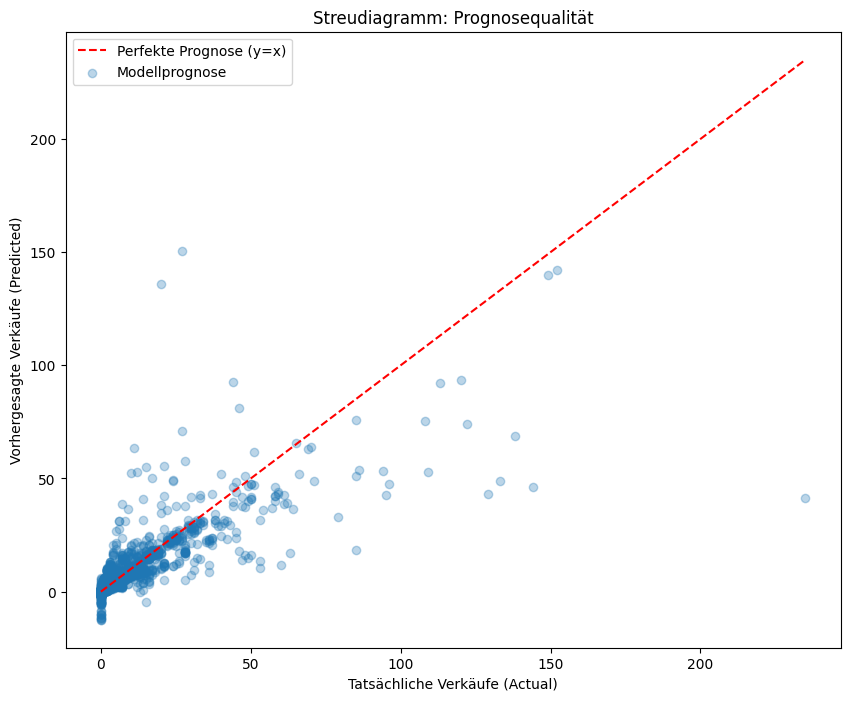

In [29]:
plt.figure(figsize=(10, 8))

max_val = y_test.max()
plt.plot([0, max_val], [0, max_val], 'r--', label='Perfekte Prognose (y=x)')

plt.scatter(y_test, y_pred, alpha=0.3, label='Modellprognose')

plt.xlabel('Tatsächliche Verkäufe (Actual)')
plt.ylabel('Vorhergesagte Verkäufe (Predicted)')
plt.title('Streudiagramm: Prognosequalität')
plt.legend()
plt.show()

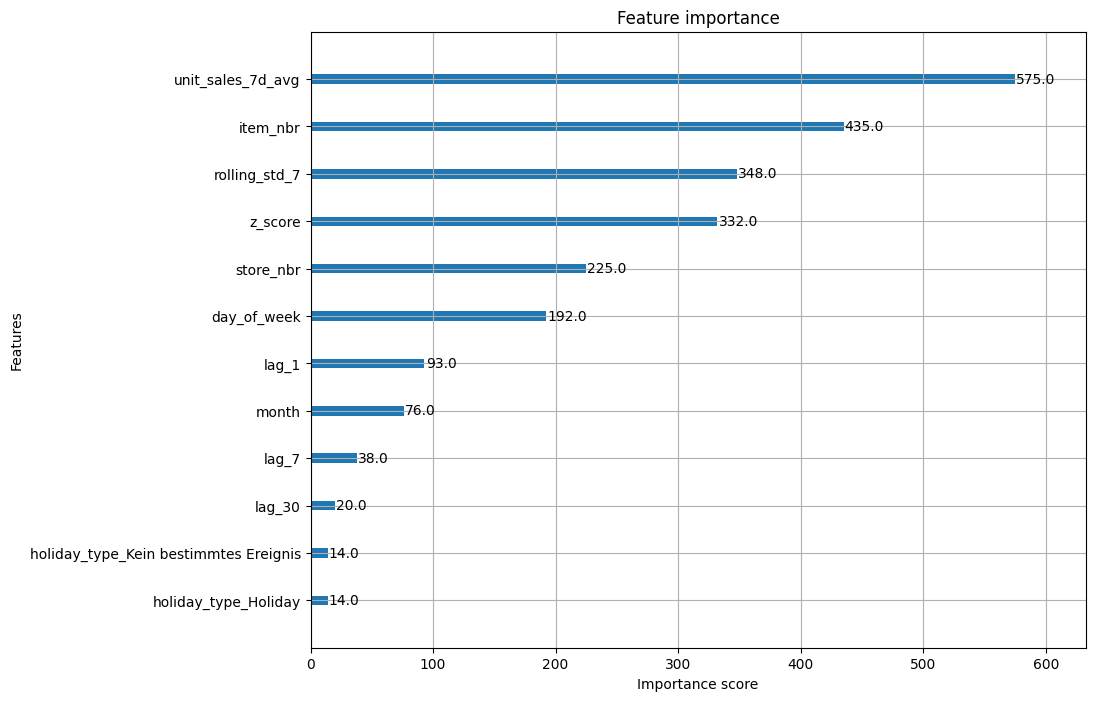

In [30]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(final_model, ax=ax)
plt.show()

## MLflow-Setup für XGBoost

In diesem Abschnitt wird MLflow genutzt, um das Training und die Bewertung des XGBoost-Modells automatisch zu protokollieren.
Alle wichtigen Informationen – wie Parameter, Metriken, Modelle und Diagramme – werden gespeichert, damit die Experimente vergleichbar und reproduzierbar bleiben.

Der Code:

- erstellt ein MLflow-Experiment (XGBoost_Basislinie),

- trainiert das Modell und berechnet Prognosemetriken,

- speichert alle Ergebnisse und das Modell direkt in MLflow.

So wird sichergestellt, dass jede Modellversion dokumentiert ist und später leicht verglichen oder erneut geladen werden kann.
Ein zentraler Schritt für Nachvollziehbarkeit und sauberes Experiment-Tracking.

In [31]:
!pip install mlflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 752.6/752.6 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 14.8 MB/s eta 0:00:00


In [32]:
# MLflow-Setup für XGBoost-Basislinie

import mlflow
import mlflow.xgboost
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor

# MLflow Setup
mlflow.set_experiment("XGBoost_Basislinie")  # Name des Experiments

# Rahmenparameter definiert
baseline_params = {
    "n_estimators": 250,
    "learning_rate": 0.1,
    "max_depth": 7,
    "random_state": 42,
    "n_jobs": -1,
    "objective": "reg:squarederror"
}

# Start meines 1. Laufs
with mlflow.start_run(run_name="Basis-XGB"):

    # Modellaufbau & Training
    model = XGBRegressor(**baseline_params)
    model.fit(X_train, y_train)

    # Vorhersagen
    y_pred = model.predict(X_test)

    # Metriken berechnen
    metrics = forecast_metrics(y_test, y_pred)

    # Parameter & Metriken in MLflow speichern
    mlflow.log_params(baseline_params)
    mlflow.log_metrics({k: float(v) for k, v in metrics.items()})

    # Prognose-Diagramm erstellen
    plt.figure(figsize=(8, 5))
    plt.plot(y_test, label="Wahre Werte", color="blue")
    plt.plot(y_pred, label="Vorhersage", color="orange")
    plt.title("XGBoost-Basislinie: Wahre Werte vs. Vorhersage")
    plt.xlabel("Zeitindex")
    plt.ylabel("Verkaufswert")
    plt.legend()
    plt.tight_layout()

    # Diagramm speichern und als Artefakt hochladen
    plt.savefig("forecast_plot.png")
    mlflow.log_artifact("forecast_plot.png")
    plt.close()

    # Modell selbst speichern
    mlflow.xgboost.log_model(model, artifact_path="xgb_model_baseline")

    # Tags setzen
    mlflow.set_tag("stage", "baseline")
    mlflow.set_tag("model_type", "XGBoost")

    print("✅ MLflow-Basislauf abgeschlossen!")
    print("🔍 Ergebnisse im MLflow-UI anzeigen mit:  mlflow ui")

2025/10/29 14:48:28 INFO mlflow.tracking.fluent: Experiment with name 'XGBoost_Basislinie' does not exist. Creating a new experiment.
2025/10/29 14:48:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:1115: UserWarning: [14:48:57] WARNING: /workspace/src/c_api/c_api.cc:1575: Saving model in the UBJSON format as default.  You can use a file extension: `json` or `ubj` to choose between formats.
  self.get_booster().save_model(fname)
2025/10/29 14:49:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ MLflow-Basislauf abgeschlossen!
🔍 Ergebnisse im MLflow-UI anzeigen mit:  mlflow ui


In [33]:
import mlflow
import pandas as pd

# Dein Experiment-Name aus dem Code
exp_name = "XGBoost_Basislinie"

# Experiment-ID holen
exp = mlflow.get_experiment_by_name(exp_name)

# Alle Runs als DataFrame ziehen
runs_df = mlflow.search_runs(
    experiment_ids=[exp.experiment_id],
    output_format="pandas"
)

# Nur die wichtigsten Spalten zeigen
cols = [
    "run_id", "tags.stage", "params.n_estimators", "params.learning_rate",
    "params.max_depth", "metrics.MAE", "metrics.RMSE", "metrics.MAPE"
]
display(runs_df[cols].sort_values("metrics.RMSE"))


,run_id,tags.stage,params.n_estimators,params.learning_rate,params.max_depth,metrics.MAE,metrics.RMSE,metrics.MAPE
0,3bd20e8fd7814edf8317946bdd6651e9,baseline,250,0.1,7,0.023242,0.857772,23.043865


2. Lauf – MLflow für optimiertes XGBoost-Modell

2025/10/29 14:49:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:1115: UserWarning: [14:49:17] WARNING: /workspace/src/c_api/c_api.cc:1575: Saving model in the UBJSON format as default.  You can use a file extension: `json` or `ubj` to choose between formats.
  self.get_booster().save_model(fname)
2025/10/29 14:49:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Zweiter MLflow-Lauf abgeschlossen! (Optimiertes Modell)


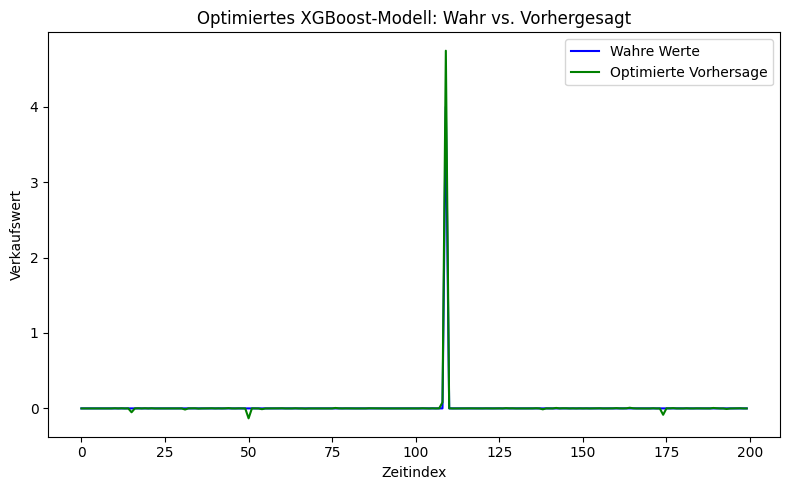

In [34]:
import mlflow
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

# Zweiter MLflow-Lauf: Optimiertes Modell
with mlflow.start_run(run_name="Optimiertes-XGB"):

    # Trainiere Modell mit den besten Parametern aus RandomizedSearchCV
    optimized_model = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=best_params["n_estimators"],
        max_depth=best_params["max_depth"],
        learning_rate=best_params["learning_rate"],
        subsample=best_params["subsample"],
        colsample_bytree=best_params["colsample_bytree"],
        random_state=42
    )

    optimized_model.fit(X_train, y_train)
    y_pred_opt = optimized_model.predict(X_test)

    # Berechne Metriken
    metrics_opt = forecast_metrics(y_test, y_pred_opt)

    # Logge Parameter und Metriken in MLflow
    mlflow.log_params(best_params)
    mlflow.log_metrics(metrics_opt)

    # Erstelle Vergleichsdiagramm (tatsächliche vs. vorhergesagte Werte)
    plt.figure(figsize=(8, 5))
    plt.plot(y_test.values[:200], label="Wahre Werte", color="blue")
    plt.plot(y_pred_opt[:200], label="Optimierte Vorhersage", color="green")
    plt.title("Optimiertes XGBoost-Modell: Wahr vs. Vorhergesagt")
    plt.xlabel("Zeitindex")
    plt.ylabel("Verkaufswert")
    plt.legend()
    plt.tight_layout()
    plt.savefig("optimized_forecast_plot.png")

    # Logge Diagramm und Modell
    mlflow.log_artifact("optimized_forecast_plot.png")
    mlflow.xgboost.log_model(optimized_model, artifact_path="xgb_model_optimized")

    # Setze Tags (optional, für Übersicht)
    mlflow.set_tag("stage", "optimized")
    mlflow.set_tag("model_type", "XGBoost")

    print("✅ Zweiter MLflow-Lauf abgeschlossen! (Optimiertes Modell)")


## 📊Vergleich Baseline vs. Optimiertes Modell: XGBoost

In diesem Schritt werden die Ergebnisse des Basismodells und des optimierten XGBoost-Modells direkt miteinander verglichen.
Dazu werden die gespeicherten MLflow-Runs geladen und die wichtigsten Metriken (z. B. RMSE, MAE, MAPE) ausgewertet.

Die Balkengrafik zeigt die Unterschiede in der Modellleistung auf einen Blick – insbesondere beim RMSE-Wert, der die Prognosegenauigkeit misst.
So lässt sich leicht erkennen, ob das Tuning tatsächlich zu einer Verbesserung der Vorhersagequalität geführt hat.

Ein wichtiger Schritt, um den Erfolg des Modelltrainings objektiv zu bewerten.

In [35]:
import pandas as pd

# Experiment-Name aus deinen Runs
exp_name = "XGBoost_Basislinie"

# Experiment-ID holen
exp = mlflow.get_experiment_by_name(exp_name)

# Alle Runs laden
runs_df = mlflow.search_runs(
    experiment_ids=[exp.experiment_id],
    output_format="pandas"
)

# Nur wichtige Spalten anzeigen
cols = [
    "tags.stage",
    "params.n_estimators",
    "params.learning_rate",
    "params.max_depth",
    "metrics.MAE",
    "metrics.RMSE",
    "metrics.MAPE"
]

comparison_df = runs_df[cols].sort_values("metrics.RMSE").reset_index(drop=True)
display(comparison_df)


,tags.stage,params.n_estimators,params.learning_rate,params.max_depth,metrics.MAE,metrics.RMSE,metrics.MAPE
0,optimized,100,0.1,5,0.030983,0.821656,38.914000
1,baseline,250,0.1,7,0.023242,0.857772,23.043865


### Visuelle Gegenüberstellung (Barplot der Metriken)

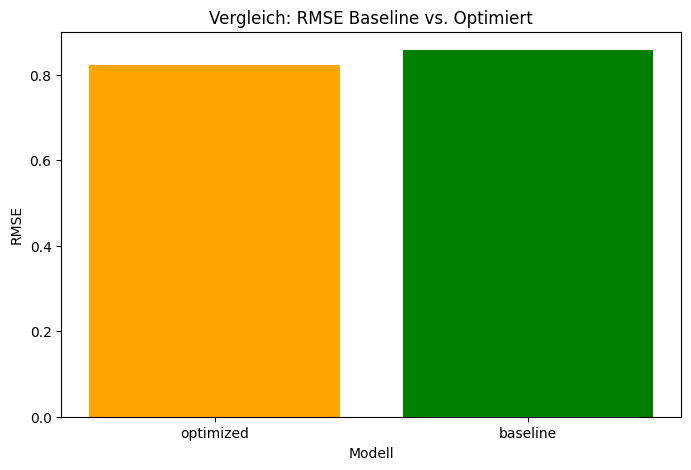

In [36]:
# Leere Werte in der Spalte "tags.stage" ersetzen
comparison_df["tags.stage"] = comparison_df["tags.stage"].fillna("unknown")

# Dann plotten
plt.figure(figsize=(8, 5))
plt.bar(comparison_df["tags.stage"], comparison_df["metrics.RMSE"], color=["orange", "green"])
plt.title("Vergleich: RMSE Baseline vs. Optimiert")
plt.ylabel("RMSE")
plt.xlabel("Modell")
plt.show()


In diesem Schritt wird aus allen gespeicherten MLflow-Runs automatisch das Modell mit dem besten RMSE-Wert ermittelt – also jenes, das die genauesten Vorhersagen liefert.

Der Code durchsucht die gespeicherten Ergebnisse, gibt die beste Run-ID aus und lädt das entsprechende Modell direkt aus MLflow.
Dadurch kannst du das leistungsstärkste Modell jederzeit wiederverwenden, ohne es neu trainieren zu müssen.

Ein wichtiger Schritt für Effizienz und Nachvollziehbarkeit im Modellmanagement.

In [37]:
import mlflow
import mlflow.xgboost
import pandas as pd

# Name deines MLflow-Experiments
exp_name = "XGBoost_Basislinie"

# Experiment holen
exp = mlflow.get_experiment_by_name(exp_name)

# Alle Runs abrufen
runs_df = mlflow.search_runs(
    experiment_ids=[exp.experiment_id],
    output_format="pandas"
)

# Besten Run anhand des niedrigsten RMSE finden
best_run = runs_df.loc[runs_df["metrics.RMSE"].idxmin()]
best_run_id = best_run["run_id"]

print("🏆 Bestes Modell gefunden!")
print(f"Stage: {best_run['tags.stage']}")
print(f"RMSE: {best_run['metrics.RMSE']:.4f}")
print(f"Run-ID: {best_run_id}")


🏆 Bestes Modell gefunden!
Stage: optimized
RMSE: 0.8217
Run-ID: 28b3dc886dc841428d3b6376e0fcd1b1


In [38]:
model_uri = f"runs:/{best_run_id}/xgb_model_optimized"

# Der Rest bleibt gleich
best_model = mlflow.xgboost.load_model(model_uri)
print("✅ Modell erfolgreich geladen!")

✅ Modell erfolgreich geladen!


/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:1124: UserWarning: [14:49:28] WARNING: /workspace/src/c_api/c_api.cc:1511: Unknown file format: `xgb`. Using UBJSON (`ubj`) as a guess.
  self.get_booster().load_model(fname)


# Feature-Spalten als Artefakt speichern

In [39]:
import json
import os

# Beispiel: deine verwendeten Feature-Spalten
feature_columns = [
    "store_nbr", "item_nbr", "onpromotion", "z_score",
    "year", "month", "day_of_week", "unit_sales_7d_avg"
]

# Erstelle einen Artefakt-Ordner, falls er noch nicht existiert
os.makedirs("artifacts", exist_ok=True)

# Speichere die Feature-Spalten als JSON-Datei
with open("artifacts/feature_columns.json", "w") as f:
    json.dump(feature_columns, f)

print("✅ Feature-Spalten erfolgreich als JSON-Artefakt gespeichert!")


✅ Feature-Spalten erfolgreich als JSON-Artefakt gespeichert!


In [40]:
from google.colab import files
files.download("/content/artifacts/feature_columns.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>